<h2>Algorithm X</h2>
<ol> 
    <li> Construct a matrix, A with <i>n</i> columns, where <i>n</i> is the sum of the number of elements used to cover the field and the number of cells to be covered - this ensures we have a way of identifying which elements cover which fields - this is not 100% necessary if we're using a single shape only. In our case we do not need to worry about the exact coverage of the elements columns - we are going to use the same shape more than one - only one shape in the most extreme cases.</li>
    <li> Construct rows use to represent all possible valid positions of the covering elements - 1 in the column identifying the piece and 1s in all the columns identifying cells covered by given element.</li>
    <li> Look for solutions that have exaclty one 1 in each column, i.e. each cell is covered by one element only and there are no overlapping elements.</li>
    <ol> 
        <li>If matrix A is empty (all 0s) - problem solved, terminate successfully</li>
        <li>Deterministically choose column, c - chooce column which has the fewest 1s, leading to the lowest number of branches in laters stages of the algorithm</li>
        <li>Nondeterministically chooise a row, r such that A[r, c] = 1 - this is the place where the algorithm splits into small subalgorithms</li>
        <li>Include r in the partial solution</li>
        <li>Choose all the columns, j such that A[r, j] = 1 - this selects columns that are solved by the currently selected row, r
        <li>Select all the rows, i for each of the columns, j such that A[i, j] = 1 - this selects rows that contain 1s in columns already solved by row r.
        <li>Delete all the columns j and rows i (this includes the deterministically chosen row, r in the step above) - this removes columns that have already been solved by row r and rows that cover the columns already covered by row r - we make sure we cover each cell only once.
        <li>Repeat the algorithm recursively on the reduced matrix A (with columns and rows removed in the step above) - go back to the first step with checking whether the remaining matrix is empty.
    </ol>
</ol>

<h2>To-do list</h2>
<ul>
    <li> Algorithm stops after the first solution is found - we will have a case where at least tens of solutions are valid and don't want to go through all of them
</ul>

In [1]:
%matplotlib inline

from matplotlib import colors
import matplotlib.pyplot as plt
import numpy as np
import random
import scipy.signal as ssignal

In [2]:
class Tiling:
    def __init__(self, _beampositions = np.zeros((1,1)), _random = False, _usebeams=396):
        self.usebeams = _usebeams
        self.beampositions = _beampositions
        self.random = _random
        self.solution = []
        
        if self.random:
            #self.columns = random.randrange(50,100)
            #self.rows = random.randrange(50, 100)
            
            self.columns = 406
            self.rows = 812
            
            print("Random array with %i rows and %i columns" % (self.rows, self.columns))
            
    def PlotBeams(self):
        fig = plt.figure(figsize=(15,10))
        ax = fig.gca()
    
    def PrepareCoverage(self):
        print("Preparing the coverage matrix...")
        
        if self.random:
            self.coverage = np.zeros((self.rows, self.columns))
            for row in np.arange(self.rows):
                for column in np.arange(self.columns):
                    self.coverage[row, column] = random.choice([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])
                    
        self.columnids = np.arange(self.coverage.shape[1])
        self.rowids = np.arange(self.coverage.shape[0])
    
    def SetCoverage(self, _coverage):
        
        self.coverage = np.copy(_coverage)
        self.columnids = np.arange(self.coverage.shape[1])
        self.rowids = np.arange(self.coverage.shape[0])
    
    def ShowCoverage(self):
        print(self.coverage)
        
        fig = plt.figure(figsize=(15,10))
        ax = fig.gca()
        
        cmap = colors.ListedColormap(['white', 'black'])
        
        self.coverageimage = ax.imshow(self.coverage, aspect='equal', interpolation='none', cmap=cmap)
    
    ### REMEMBER TO SKIP THE FIRST COLUMN IN ALL CALCULATIONS - IT CONTAINS THE ORIGINAL ROW INDICES!! ###
    
    def ShowSolution(self):
        
        fig = plt.figure(figsize=(15,10))
        ax = fig.gca()
        cmap = colors.ListedColormap(['white', 'black'])
        ax.imshow(self.coverage[sorted(self.solution), :], aspect='equal', interpolation='none', cmap=cmap)
        ax.set_yticks(np.arange(len(self.solution)))
        ax.set_yticklabels(sorted(self.solution))
    
    def Solve(self, array, columnids, rowids):
        print("Finding the optimum tiling...")
        
        print("Current partial solution: ", self.solution)
        
        if columnids.size != 0:
            print("Array is not empty...")
            
            columnsum = np.sum(array, axis=0)
            
            if 0 in columnsum:
                # This violates part C of algorithm - A[r,c] should have 1 in it and not 0
                print("Solution does not exist!")
                print("\n\n")

            else:

                mincolumns = np.where(columnsum == np.min(columnsum))[0]
                choosecolumn = mincolumns[0]
                rows = np.where(array[:, choosecolumn] == 1)[0]
                
                for row in rows:

                    print("Working with row ", rowids[row])

                    self.solution.append(rowids[row])

                    solvedcolumns = np.where(array[row, :] == 1)[0]
                    print("Colums solved ", solvedcolumns)

                    solvingrows = np.unique(np.where(array[:, solvedcolumns] == 1)[0])
                    print("Rows that solve these columns ", solvingrows)

                    reduced = np.delete(np.delete(array, solvedcolumns, axis=1), solvingrows, axis=0)
                    reducedcolumnids = np.delete(columnids, solvedcolumns, axis=0)
                    reducedrowids = np.delete(rowids, solvingrows, axis=0)

                    print("Reduced array ", reduced)
                    self.Solve(reduced, reducedcolumnids.copy(), reducedrowids.copy())

                    if self.solution:
                        self.solution.pop()

        else:
            print("Coverage array is empty. We have a valid solution!")
            print("Solving rows ", self.solution)
            print("\n")
            print("Solution: ")
            self.ShowSolution()

In [3]:
testarray = np.zeros((5, 8))

testarray.shape[1]

for row in np.arange(testarray.shape[0]):
    for column in np.arange(testarray.shape[1]):
        testarray[row, column] = random.choice([0, 0, 1])

print(testarray)

[[0. 0. 0. 1. 0. 1. 1. 1.]
 [1. 0. 0. 1. 0. 0. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 1.]]


In [4]:


### 0 3 4 is a solution
#'''
testarray = np.zeros((6, 7))
testarray[0, :] = [0, 0, 1, 0, 1, 1, 0]
testarray[1, :] = [1, 0, 0, 1, 0, 0, 1]
testarray[2, :] = [0, 1, 1, 0, 0, 1, 0]
testarray[3, :] = [1, 0, 0, 1, 0, 0, 0]
testarray[4, :] = [0, 1, 0, 0, 0, 0, 1]
testarray[5, :] = [0, 0, 0, 1, 1, 0, 1]
#'''

### 1 3 5 is a solution

'''
testarray = np.zeros((6, 7))
testarray[0, :] = [1, 0, 0, 1, 0, 0, 1]
testarray[1, :] = [1, 0, 0, 1, 0, 0, 0]
testarray[2, :] = [0, 0, 0, 1, 1, 0, 1]
testarray[3, :] = [0, 0, 1, 0, 1, 1, 0]
testarray[4, :] = [0, 1, 1, 0, 0, 1, 1]
testarray[5, :] = [0, 1, 0, 0, 0, 0, 1]
'''
#testarray[:, 0] = np.arange(testarray.shape[0])
#testarray[0, :] = np.arange(testarray.shape[1])

print(testarray)


[[0. 0. 1. 0. 1. 1. 0.]
 [1. 0. 0. 1. 0. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0.]
 [1. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 1. 0. 1.]]


In [5]:
#testarray = np.zeros((12,10))
#np.fill_diagonal(testarray, 1, wrap=True)

[[0. 0. 1. 0. 1. 1. 0.]
 [1. 0. 0. 1. 0. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0.]
 [1. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 1. 0. 1.]]


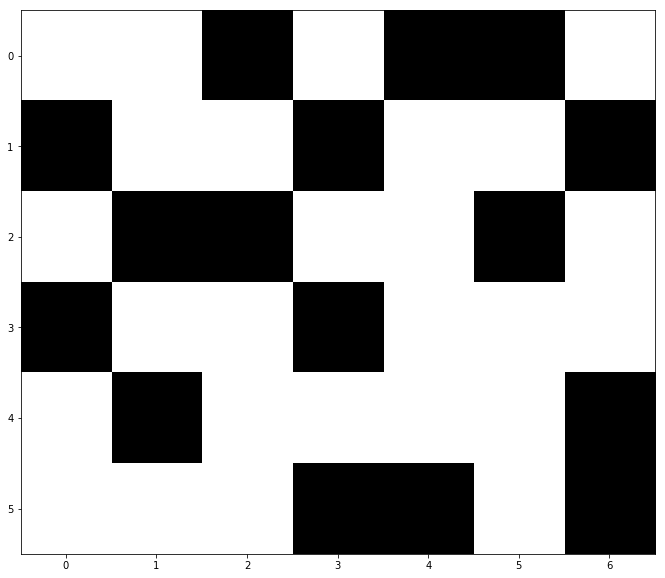

In [6]:
tiling = Tiling(_random=False)
#tiling.PrepareCoverage()
tiling.SetCoverage(testarray)
tiling.ShowCoverage()


Finding the optimum tiling...
Current partial solution:  []
Array is not empty...
Working with row  1
Colums solved  [0 3 6]
Rows that solve these columns  [1 3 4 5]
Reduced array  [[0. 1. 1. 1.]
 [1. 1. 0. 1.]]
Finding the optimum tiling...
Current partial solution:  [1]
Array is not empty...
Working with row  2
Colums solved  [0 1 3]
Rows that solve these columns  [0 1]
Reduced array  []
Finding the optimum tiling...
Current partial solution:  [1, 2]
Array is not empty...
Solution does not exist!



Working with row  3
Colums solved  [0 3]
Rows that solve these columns  [1 3 5]
Reduced array  [[0. 1. 1. 1. 0.]
 [1. 1. 0. 1. 0.]
 [1. 0. 0. 0. 1.]]
Finding the optimum tiling...
Current partial solution:  [3]
Array is not empty...
Working with row  0
Colums solved  [1 2 3]
Rows that solve these columns  [0 1]
Reduced array  [[1. 1.]]
Finding the optimum tiling...
Current partial solution:  [3, 0]
Array is not empty...
Working with row  4
Colums solved  [0 1]
Rows that solve these column

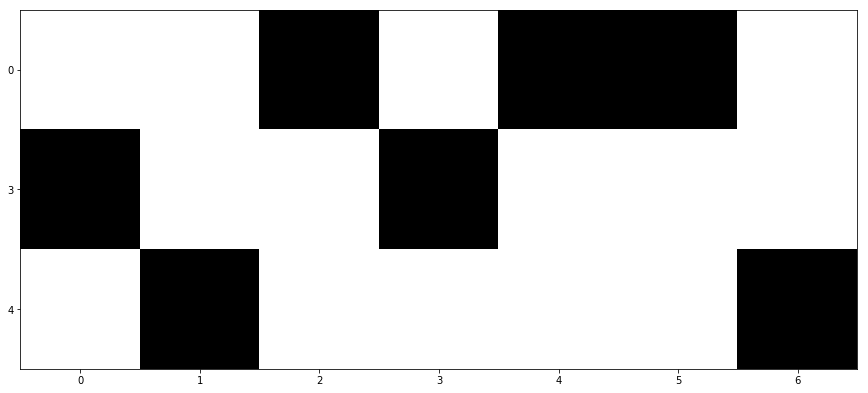

In [7]:
tiling.Solve(tiling.coverage, tiling.columnids, tiling.rowids)

In [8]:
column_sums = np.sum(testarray[:, 1:], axis=0)
print(column_sums)
columns = np.where(column_sums == np.amin(column_sums))[0]
print(columns)
print(columns[0])

rows = np.where(testarray[:, columns[0] + 1] == 1)[0]

print(rows)

for row in rows:
    print("Looking at row %d now..." % row)
    solvedcolumns = np.where(testarray[row, 1:] == 1)[0] + 1
    print("Solved columns", solvedcolumns)

    solvingrows = np.unique(np.where(testarray[:, solvedcolumns] == 1)[0])
    print("Solving rows", solvingrows)
    
    tmp = np.delete(testarray, solvedcolumns, axis=1)
    tmp2 = np.delete(tmp, solvingrows, axis=0)
    
    solution = np.delete(np.delete(testarray, solvedcolumns, axis=1), solvingrows, axis=0)
    
print(tmp2)
print(solution)
if 0 in column_sums:
    print("Solution does not exist")

[2. 2. 3. 2. 2. 3.]
[0 1 3 4]
0
[2 4]
Looking at row 2 now...
Solved columns [1 2 5]
Solving rows [0 2 4]
Looking at row 4 now...
Solved columns [1 6]
Solving rows [1 2 4 5]
[[0. 1. 0. 1. 1.]
 [1. 0. 1. 0. 0.]]
[[0. 1. 0. 1. 1.]
 [1. 0. 1. 0. 0.]]


In [9]:
testarray = np.ones((2,3))
np.sum(testarray, axis=0)

array([2., 2., 2.])

In [10]:
np.sum(np.delete(testarray, [0, 1], axis=0), axis=0)

array([0., 0., 0.])

In [11]:
mylist = [0, 1, 2, 3]
print(mylist)
mylist.append(4)
print(mylist)
mylist.pop()
print(mylist)

[0, 1, 2, 3]
[0, 1, 2, 3, 4]
[0, 1, 2, 3]


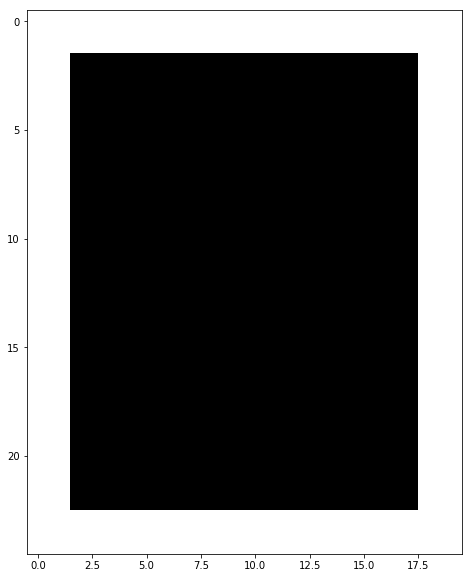

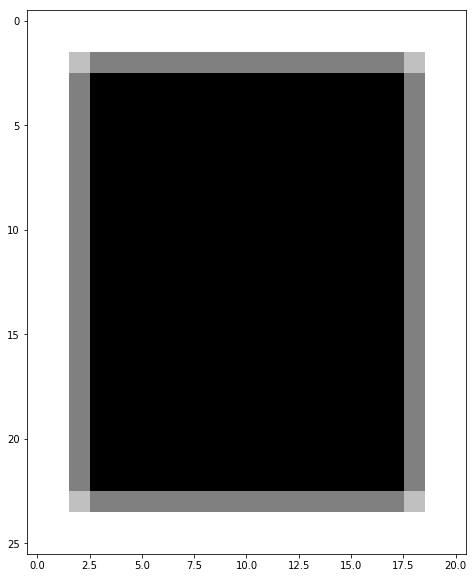

In [12]:
testcoverage = np.ones((25, 20))
testcoverage[:, 0:2] = 0
testcoverage[:, -2:] = 0
testcoverage[0:2, :] = 0
testcoverage[-2:, :] = 0

testshape = np.ones((2,2))

fig = plt.figure(figsize=(15,10))
ax = fig.gca()

cmap = colors.ListedColormap(['white', 'black'])
ax.imshow(testcoverage, aspect='equal', interpolation='none', cmap=cmap)
     
    
testconvolved = ssignal.convolve2d(testcoverage, testshape) #, testshape)

fig = plt.figure(figsize=(15,10))
ax = fig.gca()

cmap2 = colors.ListedColormap(['white', 'silver', 'grey', 'black'])

conv = ax.imshow(testconvolved, aspect='equal', interpolation='none', cmap=cmap2)
#fig.colorbar(conv, ax=ax)

0.007001487937098321
[0.00700149 0.00700149 0.00700149 0.00700149 0.00700149 0.00700149
 0.00700149 0.00700149 0.00700149]
[  0  41  54  95 108 145 158 195 208 245 256 287 298 329 338 363 370 389
 394]
[0.00700149 0.01400298 0.02100446 0.02800595 0.03500744 0.04200893
 0.04901042 0.0560119  0.06301339]


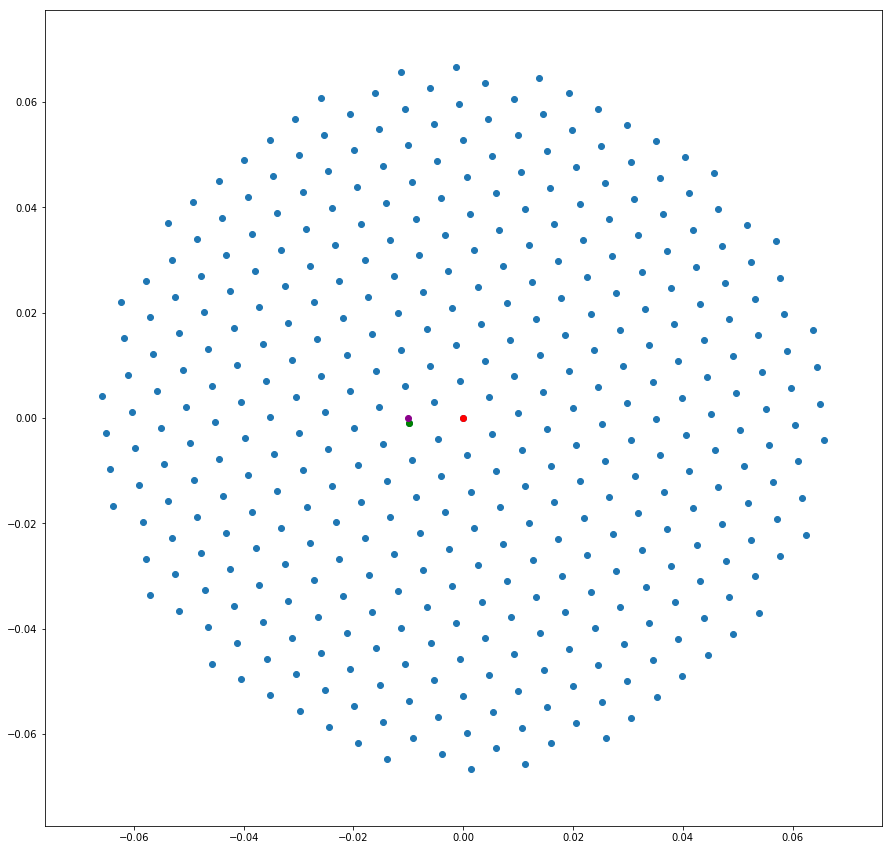

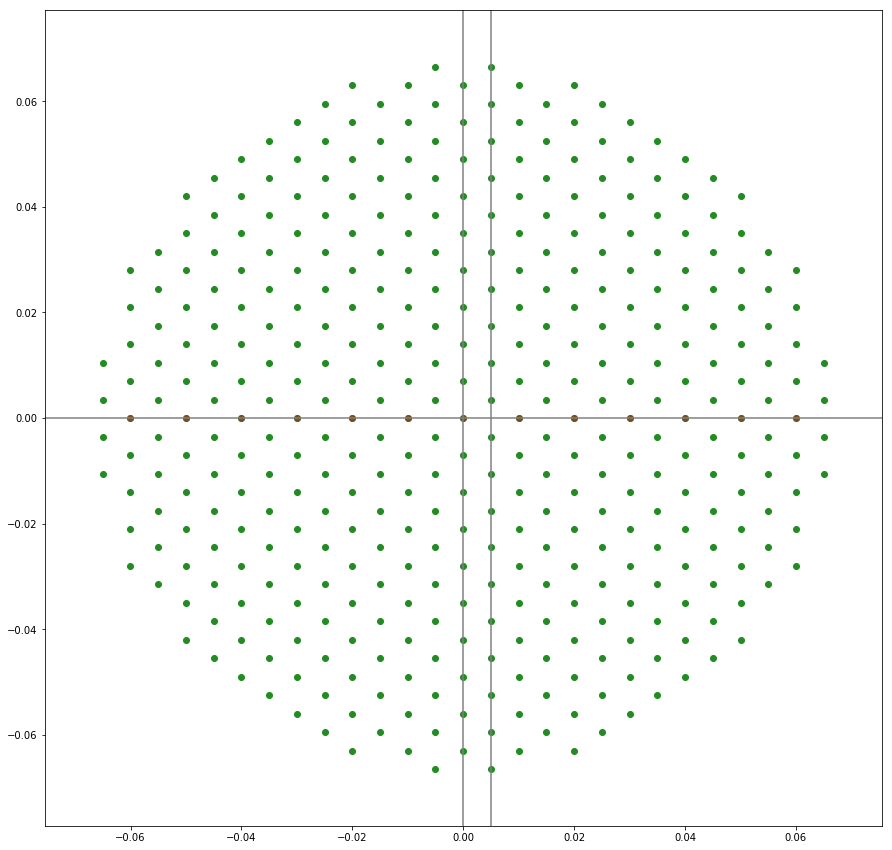

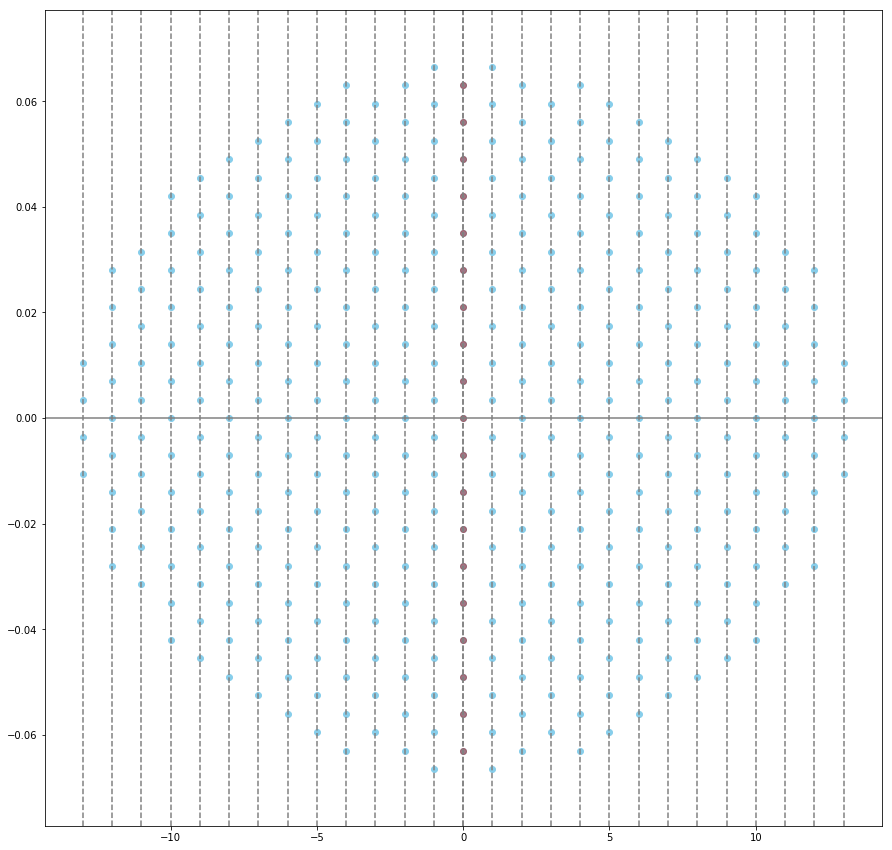

In [122]:
### !!! CHANGE FOR EVERY test_beams.dat FILE !!! ###
# Current angle printed out by the software: -174.503107

testbeams = np.loadtxt('test_beams.dat', delimiter='\t')

fig = plt.figure(figsize=(15,15))
ax = fig.gca()

ax.scatter(testbeams[:, 0], testbeams[:, 1])
ax.scatter(testbeams[0, 0], testbeams[0, 1], color='red')
ax.scatter(testbeams[1, 0], testbeams[1, 1], color='green')

centralbeam = testbeams[0, :]
nextbeam = testbeams[1, :]

### The transformations described belowe will not affect the general results ###
### We have to worry about the relative placement of the beams and not their absolute positions ### 
### Need to rotate the beam positions, so that the 'principal axis' is parallel to the x-axis ###

angle = np.rad2deg(np.arctan(nextbeam[1] / nextbeam[0]))
beamsign = np.sign(nextbeam[0])


angle = -1.0 * np.arctan(nextbeam[1] / nextbeam[0])
rotation = np.array(((np.cos(angle), -np.sin(angle)), (np.sin(angle), np.cos(angle))))

rotated = np.matmul(rotation, testbeams[1, :].reshape(2, 1))
ax.scatter(rotated[0], rotated[1], color='darkmagenta')

beamsrotated = np.apply_along_axis(np.matmul, 1, testbeams, np.transpose(rotation))
fig = plt.figure(figsize=(15,15))
ax = fig.gca()

ax.scatter(beamsrotated[:, 0], beamsrotated[:, 1], color='forestgreen')
ax.axhline(0.0, color='grey')
ax.axvline(0.0, color='grey')

### Need to normalise the distances between the beams - each columns is offset by 1 and each row is offset by 1 ###
### Get the x positions for all the beams in the first row ###
### Use average separation between the beams there to take minor differences due to rounding into account ###

## This implementation will not find all of them in case there are some rounding error problems ###
horizontal = np.where(beamsrotated[:, 1] == 0.0)[0]
#print(horizontal)
horizontaleven = horizontal[(np.mod(horizontal, 2) == 0) & (horizontal != 0)]
#print(horizontaleven)
#print(beamsrotated[horizontaleven, 0])
#print(beamsrotated[horizontaleven, 0] / (horizontaleven / 2))

# Final division by 2 make sure we take optain the lowest shift in x
# The difference in x-coordinate for neighbouring rows is half the separation between beams in the same row
minhordist = np.sum(beamsrotated[horizontaleven, 0] / (horizontaleven / 2)) / len(horizontaleven) / 2.0
#print(minhordist)

ax.scatter(beamsrotated[horizontal, 0], beamsrotated[horizontal, 1], color='firebrick', alpha=0.5)
ax.axvline(minhordist, color='grey')

normalisation = np.array((1.0 / minhordist, 1))

seminormalised = np.rint(np.apply_along_axis(np.multiply, 1, beamsrotated, normalisation))
seminormalised[:, 1] = beamsrotated[:, 1]


fig = plt.figure(figsize=(15,15))
ax = fig.gca()

vertical = np.where(seminormalised[:, 0] == 0.0)[0]
verticalpositives = seminormalised[vertical[seminormalised[vertical, 1] > 0], 1]

minverdist = np.sum(seminormalised[vertical[seminormalised[vertical, 1] > 0], 1] / (np.arange(len(verticalpositives)) + 1)) / len(verticalpositives)

print(minverdist)

print(verticalpositives / (np.arange(len(verticalpositives)) + 1))

print(vertical)
print(verticalpositives)

ax.scatter(seminormalised[:, 0], seminormalised[:, 1], color='skyblue')
ax.scatter(seminormalised[vertical, 0], seminormalised[vertical, 1], color='firebrick', alpha=0.5)

ax.axhline(0.0, color='grey')

for column in np.arange(14):
    ax.axvline(column, color='grey', linestyle='--')
    ax.axvline(-1.0 * column, color='grey', linestyle='--')
    
normalisation = np.array((1.0, 1.0 / minverdist))

fullynormalised = np.rint(np.apply_along_axis(np.multiply, 1, seminormalised, normalisation))

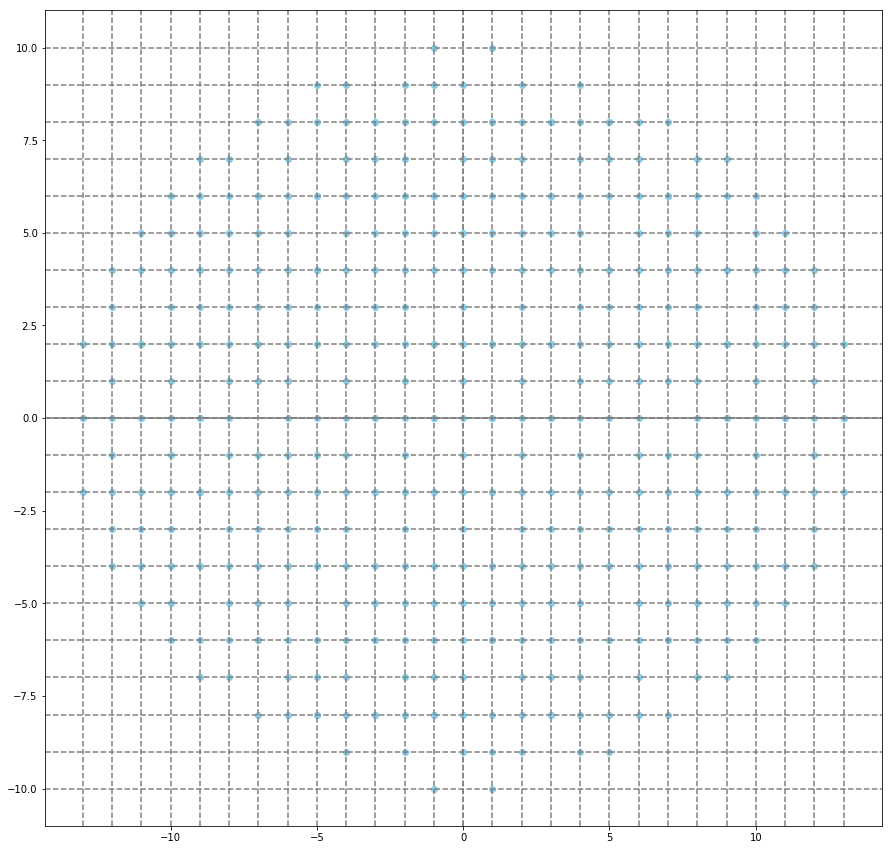

In [126]:
fig = plt.figure(figsize=(15,15))
ax = fig.gca()

ax.scatter(fullynormalised[:, 0], fullynormalised[:, 1], color='skyblue')

ax.axhline(0.0, color='grey')

for column in np.arange(14):
    ax.axvline(column, color='grey', linestyle='--')
    ax.axvline(-1.0 * column, color='grey', linestyle='--')

for row in np.arange(11):
    ax.axhline(row, color='grey', linestyle='--')
    ax.axhline(-1.0 * row, color='grey', linestyle='--')